### Load packages

In [1]:
import scanpy as sc
import episcanpy as epi
import numpy as np
import anndata as ad
import random
import copy
import pandas as pd

sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

In [58]:
# to obtain the mouse gene annotation gtf file from gencode
#!wget http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M23/gencode.vM23.primary_assembly.annotation.gtf.gz
#!gunzip -d gencode.vM23.primary_assembly.annotation.gtf.gz

# Pre-processing 10x
We need to filter the barcodes.

### Load the 10x windows count matrix

In [2]:
input_dir_10x = './data_integration_datasets/10x/merged_peaks_small/'

adata = ad.read(input_dir_10x+'atac_v1_adult_brain_fresh_5k_fragments_AllCells.h5ad')
adata

AnnData object with n_obs × n_vars = 335609 × 390259

In [3]:
# Load cellranger barcode annotation and filter
with open('./integration_benchmarking/resubmission/filtered_peak_bc_matrix/barcodes.tsv') as f:
    barcodes = f.readlines()
    barcodes = [x.rstrip('\n') for x in barcodes]

annot = []
for name in adata.obs_names.tolist():
    if name in barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata.obs['filter_barcode_cellranger'] = annot

adata = adata[adata.obs['filter_barcode_cellranger']=='keep',:].copy()
adata

AnnData object with n_obs × n_vars = 3880 × 390259
    obs: 'filter_barcode_cellranger'

In [4]:
# make the matrix binary
print(np.max(adata.X))
epi.pp.binarize(adata)
print(np.max(adata.X))

33.0
1.0


### Preliminary filtering

In [5]:
epi.pp.filter_cells(adata, min_features=100)
adata

AnnData object with n_obs × n_vars = 3872 × 390259
    obs: 'filter_barcode_cellranger', 'nb_features'

In [6]:
epi.pp.filter_features(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 3872 × 379199
    obs: 'filter_barcode_cellranger', 'nb_features'
    var: 'n_cells'

### QC and filtering

In [7]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 3872 × 379199
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells'

... storing 'filter_barcode_cellranger' as categorical


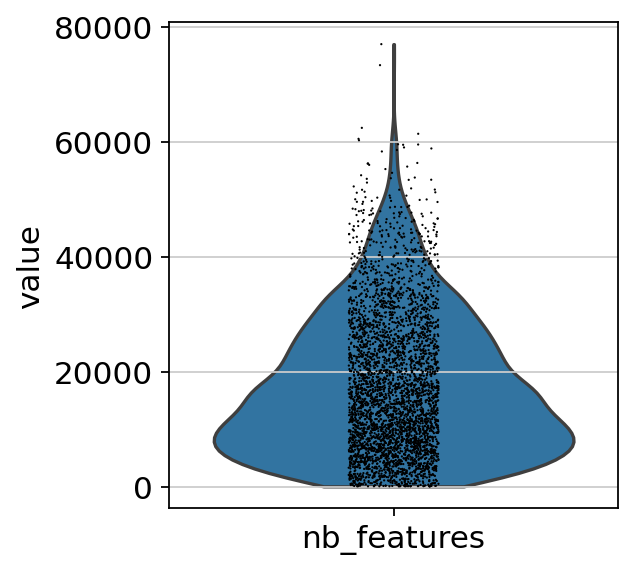

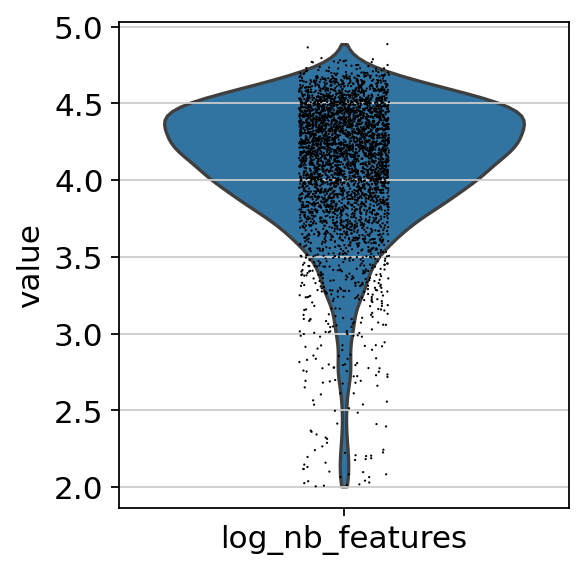

In [8]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

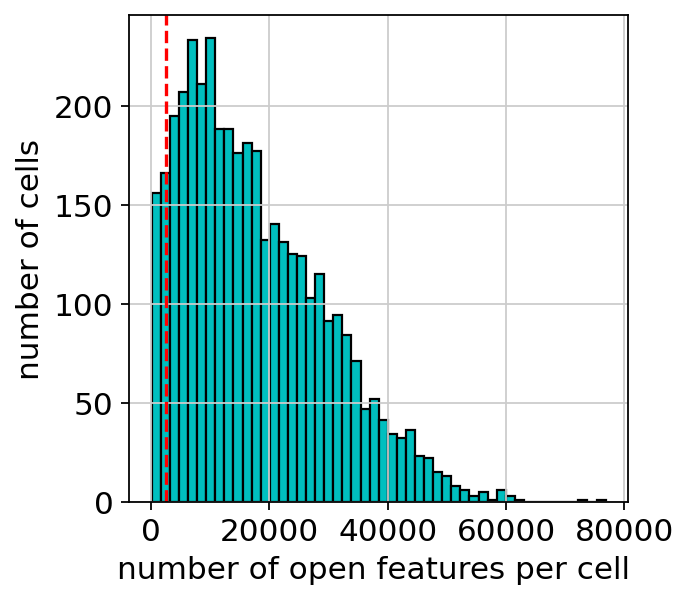

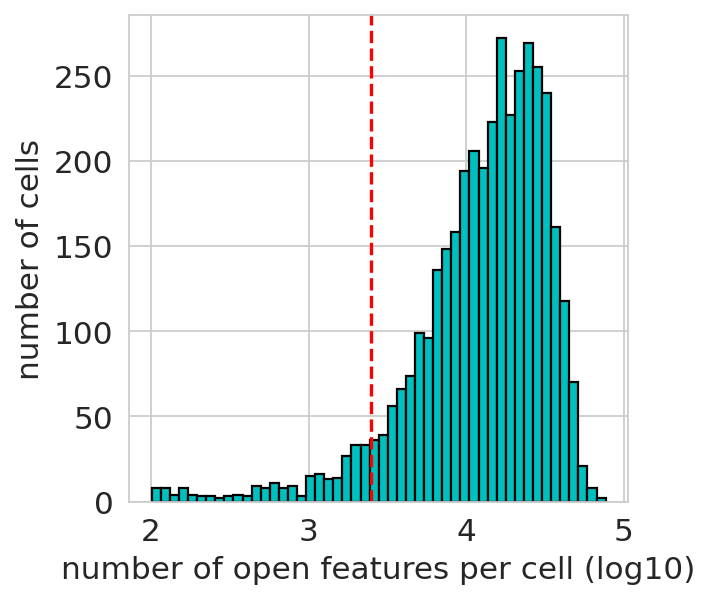

In [9]:
# set a minimum number of cells to keep 
min_features = 2500

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features, save='10x_small_geneactivity_coverage_cells_150k.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features, save='10x_small_geneactivity_coverage_cells_log10_150k.png')

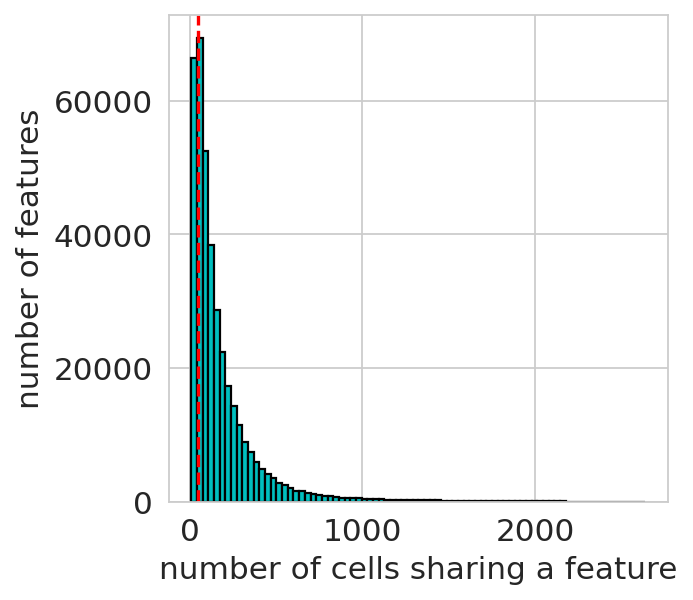

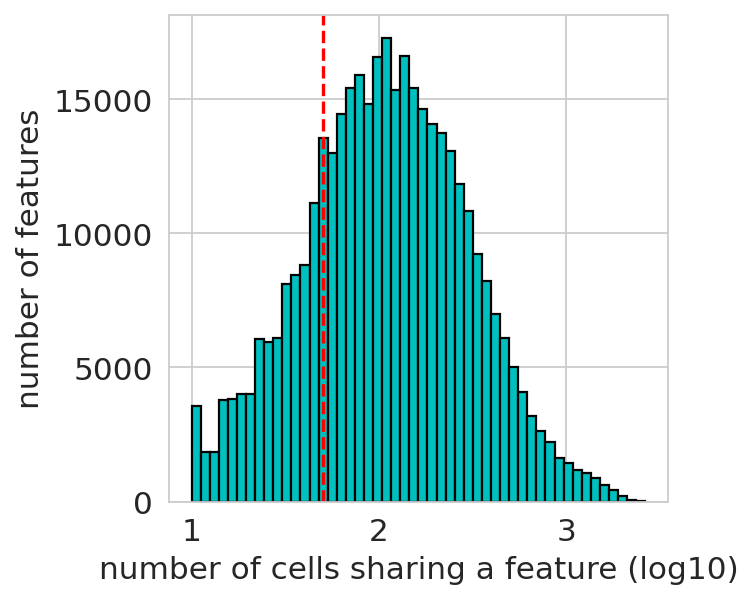

In [10]:
# minimum number of cells sharing a feature
min_cells = 50
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_small_geneactivity_coverage_150k.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_small_geneactivity_coverage_log10_150k.png')

In [11]:
min_features = 2500
epi.pp.filter_cells(adata, min_features=min_features)
adata

AnnData object with n_obs × n_vars = 3619 × 379199
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

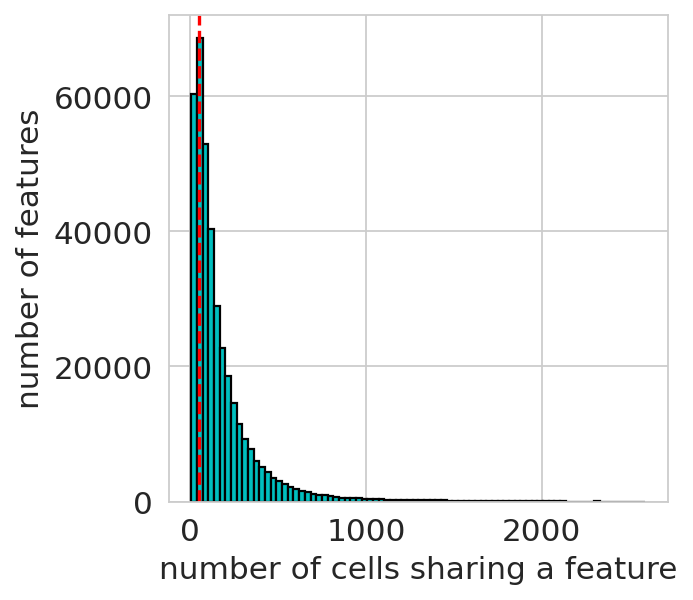

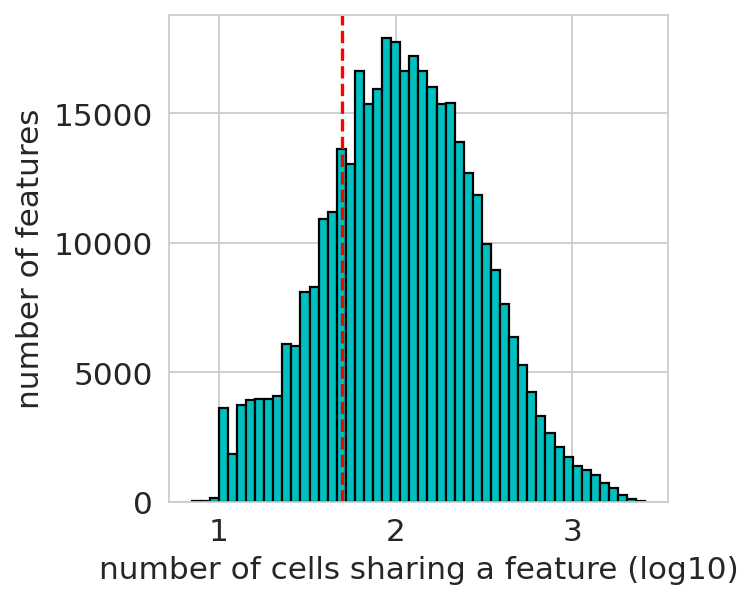

In [12]:
# minimum number of cells sharing a feature
min_cells = 50
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_small_geneactivity_coverage_150k.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_small_geneactivity_coverage_log10_150k.png')

In [13]:
min_cells = 50
epi.pp.filter_features(adata, min_cells=min_cells)
adata

AnnData object with n_obs × n_vars = 3619 × 296360
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

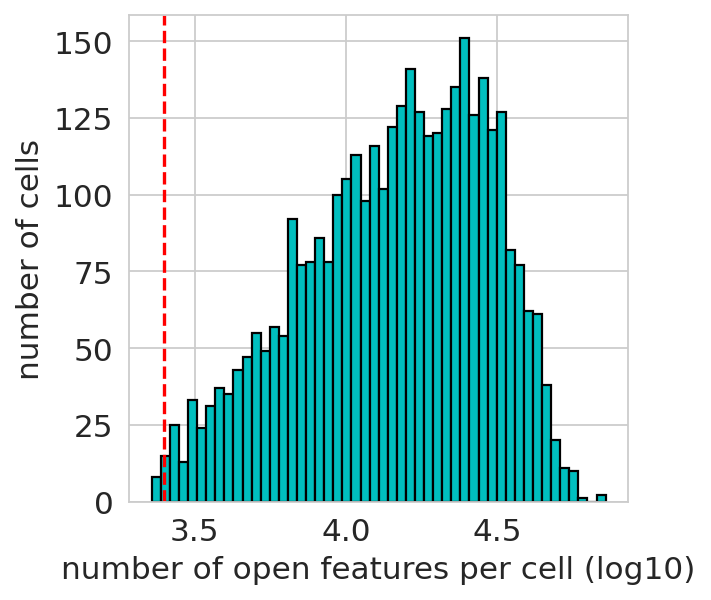

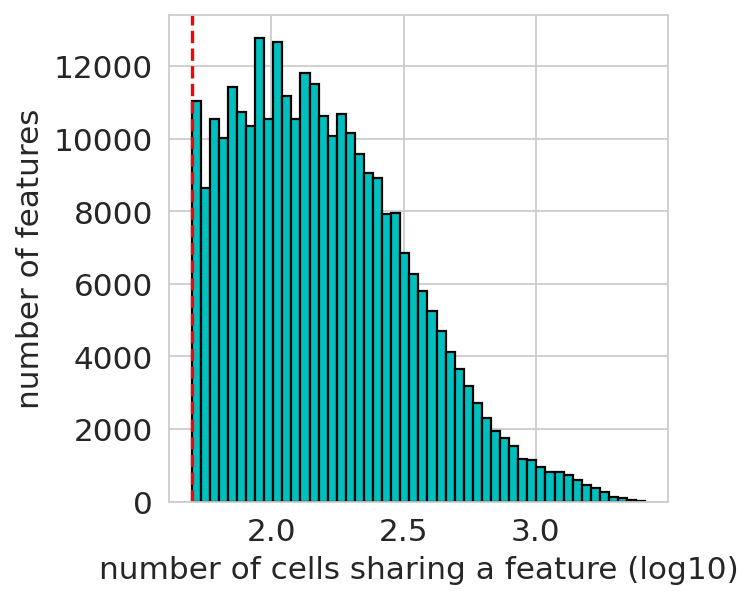

In [14]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

In [15]:
adata

AnnData object with n_obs × n_vars = 3619 × 296360
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

# Filter peaks

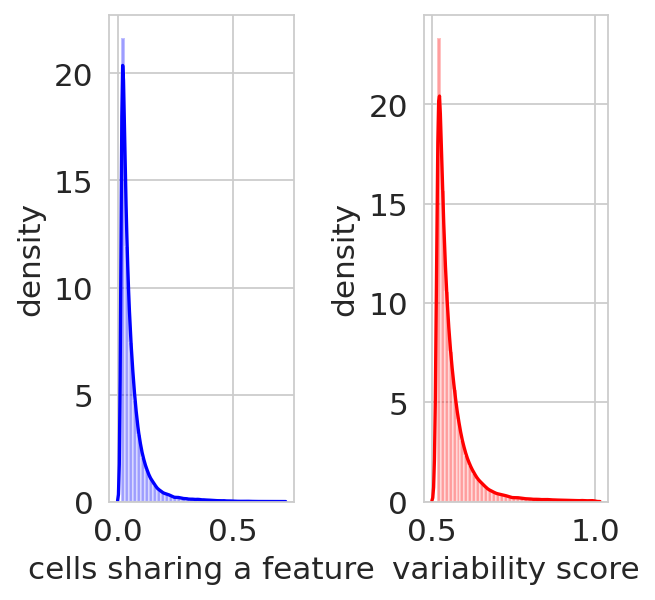

In [16]:
epi.pp.cal_var(adata)

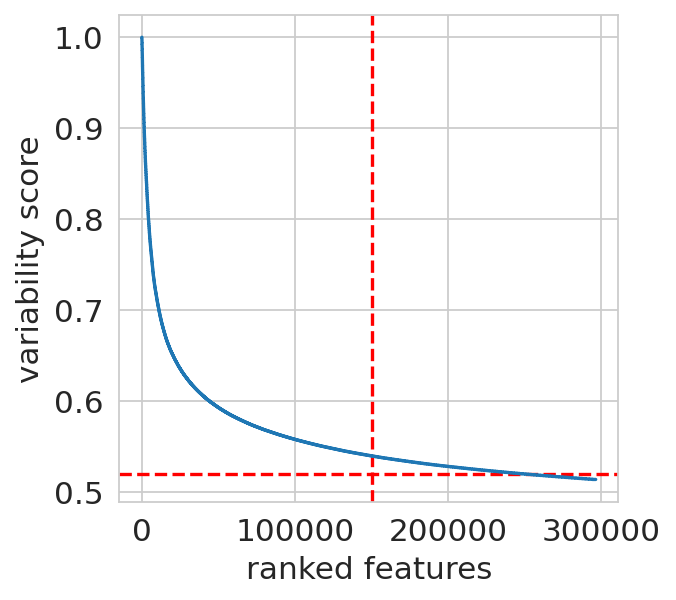

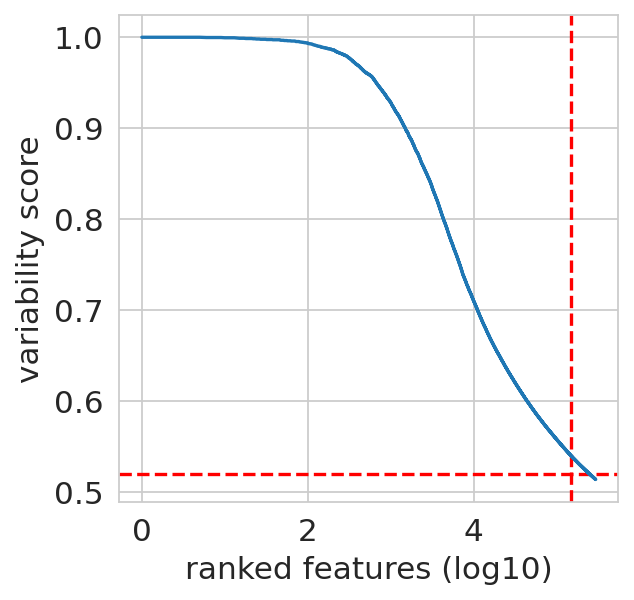

In [17]:
min_score_value = 0.52
nb_feature_selected = 150000
epi.pl.variability_features(adata,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_small_peaks_150k.png')

epi.pl.variability_features(adata,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_small_peaks_log10_150k.png')

In [18]:
# save the current matrix in the raw layer
adata.raw = adata

In [19]:
nb_feature_selected = 150000
# create a new AnnData containing only the most variable features
adata = epi.pp.select_var_feature(adata,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

In [21]:
adata

View of AnnData object with n_obs × n_vars = 3619 × 150146
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

### Generate the gene activity matrix

In [22]:
adata2 = epi.tl.geneactivity(adata, gtf_file='gencode.vM23.primary_assembly.annotation.gtf',
                             feature_type='transcript',
                            upstream=5000)

In [23]:
adata

View of AnnData object with n_obs × n_vars = 3619 × 150146
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [24]:
adata2

AnnData object with n_obs × n_vars = 3619 × 4029
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'protein_id'

In [25]:
adata2.var_names

Index(['Rp1-202', 'St18-213', 'Sntg1-202', 'Mcmdc2-205', 'Snord87-201',
       'Gm24674-201', 'A830018L16Rik-208', 'Slco5a1-202', 'Ncoa2-202',
       'Eya1-201',
       ...
       'Reps2-201', 'Gm25367-201', 'Gm44376-201', 'Frmpd4-201', 'Mid1-205',
       'Mid1-214', 'Mid1-215', 'Gm47283-201', 'Gm47283-202', 'Gm47283-203'],
      dtype='object', length=4029)

In [26]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata2.layers['counts'] = adata2.X.copy()
adata10x = adata2.copy()

### preview of the 10x gene activity

... storing 'gene_id' as categorical
... storing 'gene_type' as categorical
... storing 'gene_name' as categorical
... storing 'transcript_type' as categorical
... storing 'protein_id' as categorical


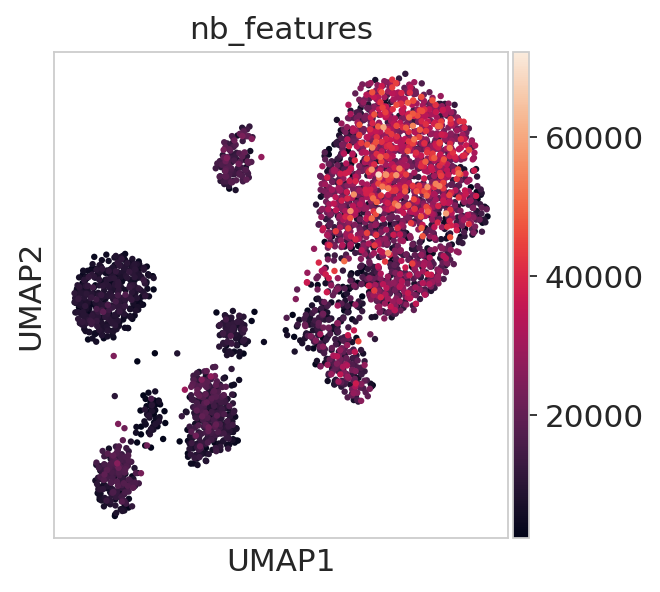

In [27]:
adata4 = adata10x.copy()
epi.pp.normalize_per_cell(adata4)
epi.pp.lazy(adata4)
sc.pl.umap(adata4, color=['nb_features'], wspace=0.3)

In [29]:
# save temporary output
adata10x.write('./integration_resubmission/gene_activity_10x_small_150k_transcripts.h5ad')

... storing 'gene_id' as categorical
... storing 'gene_type' as categorical
... storing 'gene_name' as categorical
... storing 'transcript_type' as categorical
... storing 'protein_id' as categorical


# small Fang

In [3]:
input_dir_fang = './data_integration_datasets/fang/merged_peaks_small/'
#input_dir_fang = '/home/icb/anna.danese/integration_resubmission/small_peaks/'

adata2 = ad.read(input_dir_fang+'CEMBA180305_2B_AllCells.h5ad')


adata2

AnnData object with n_obs × n_vars = 88080 × 390259 

In [5]:
set([len(x) for x in adata2.obs_names])

{32}

In [6]:
print(np.max(adata2.X))
epi.pp.binarize(adata2)
print(np.max(adata2.X))

88.0
1.0


In [7]:
epi.pp.filter_cells(adata2, min_features=100)
adata2

AnnData object with n_obs × n_vars = 13835 × 390259 
    obs: 'nb_features'

In [8]:
epi.pp.filter_features(adata2, min_cells=10)
adata2

AnnData object with n_obs × n_vars = 13835 × 365570 
    obs: 'nb_features'
    var: 'n_cells'

In [9]:
adata2.obs['log_nb_features'] = [np.log10(x) for x in adata2.obs['nb_features']]
adata2

AnnData object with n_obs × n_vars = 13835 × 365570 
    obs: 'nb_features', 'log_nb_features'
    var: 'n_cells'

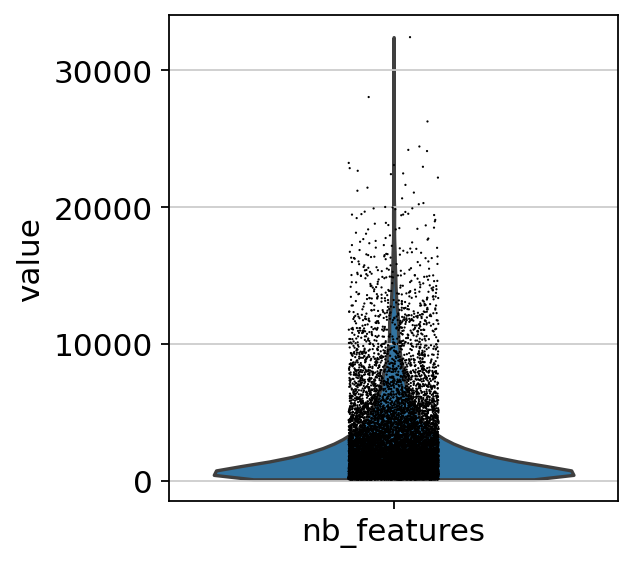

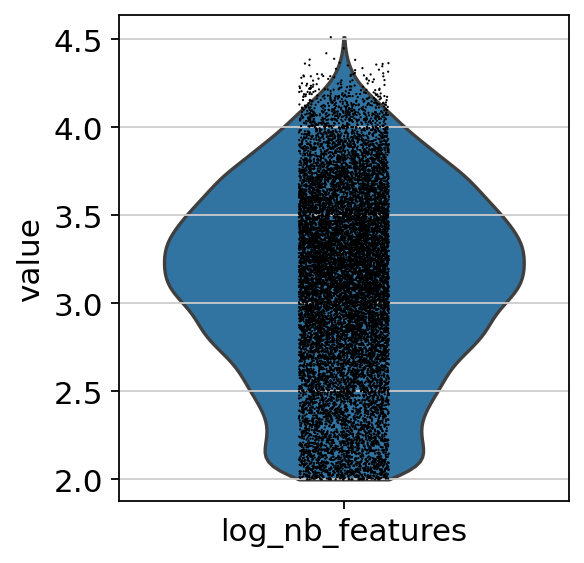

In [10]:
epi.pl.violin(adata2, ['nb_features'])
epi.pl.violin(adata2, ['log_nb_features'])

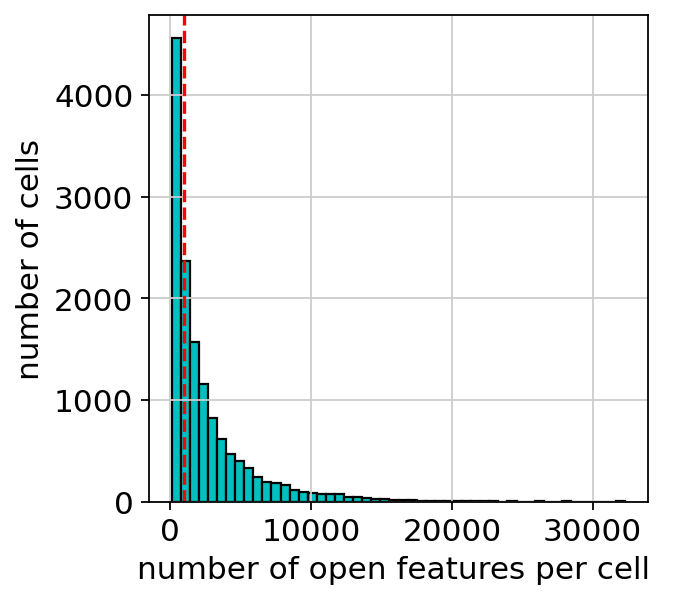

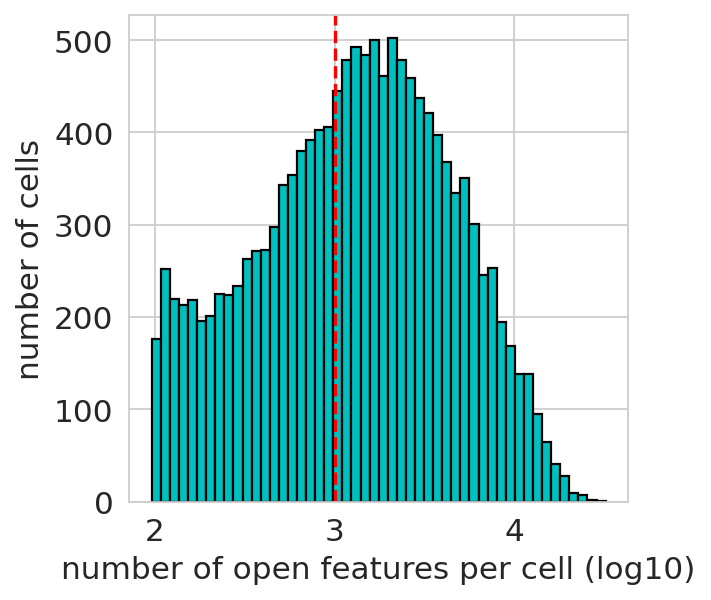

In [11]:
# set a minimum number of cells to keep 
min_features = 1000

epi.pp.coverage_cells(adata2, binary=True, log=False, bins=50,
               threshold=min_features, save='CEMBA180305_2B_geneactivity_small_coverage_cells_150k.png')
epi.pp.coverage_cells(adata2, binary=True, log=10, bins=50,
               threshold=min_features, save='CEMBA180305_2B_geneactivity_small_coverage_cells_log10_150k.png')

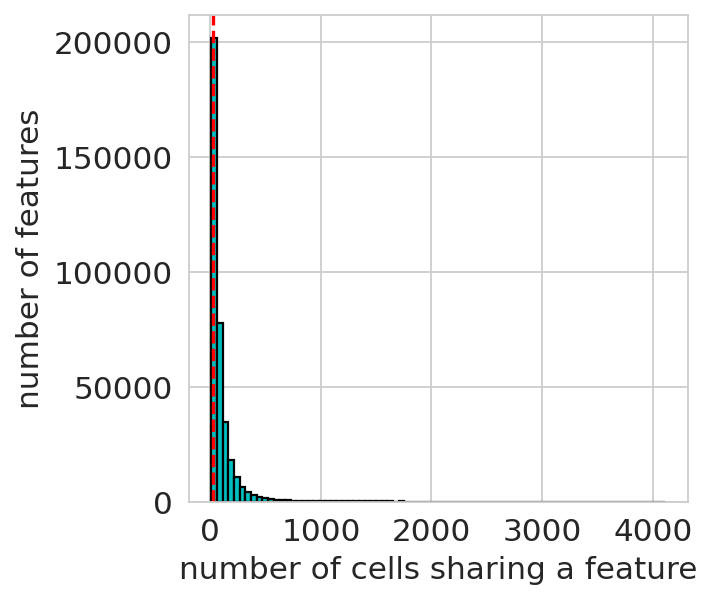

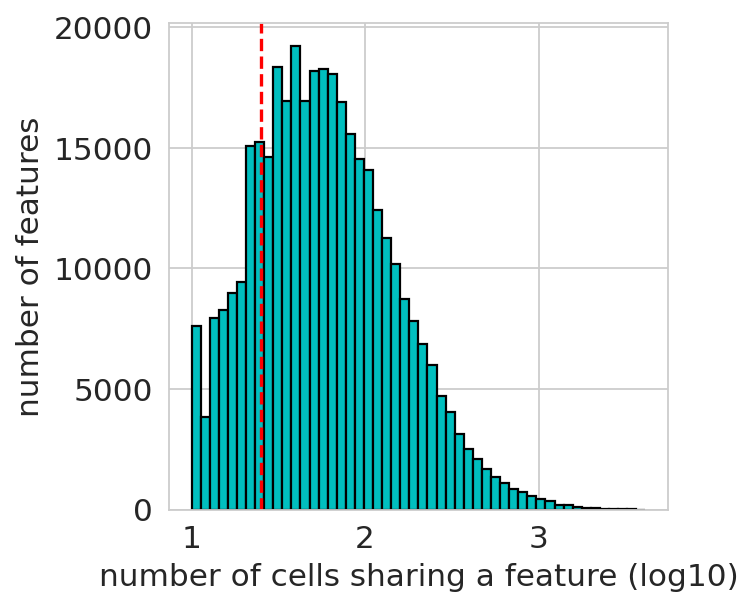

In [12]:
# minimum number of cells sharing a feature
min_cells = 25
epi.pp.coverage_features(adata2, binary=True, log=False, 
                        threshold=min_cells, save='CEMBA180305_2B_geneactivity_small_coverage_150k.png')
epi.pp.coverage_features(adata2, binary=True, log=True, 
                        threshold=min_cells, save='CEMBA180305_2B_geneactivity_small_coverage_log10_150k.png')

In [13]:
min_features = 1000
epi.pp.filter_cells(adata2, min_features=min_features)

In [14]:
k = 4000
filtered_barcodes = random.sample(adata2.obs_names.tolist(), k)
annot = []
for n in adata2.obs_names.tolist():
    if n in filtered_barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata2.obs['filter'] = annot
adata2 = adata2[adata2.obs['filter']=='keep',:].copy()
adata2

AnnData object with n_obs × n_vars = 4000 × 365570 
    obs: 'nb_features', 'log_nb_features', 'filter'
    var: 'n_cells', 'commonness'

In [15]:
epi.pp.filter_features(adata2, min_cells=25)
adata2

AnnData object with n_obs × n_vars = 4000 × 181640 
    obs: 'nb_features', 'log_nb_features', 'filter'
    var: 'n_cells', 'commonness'

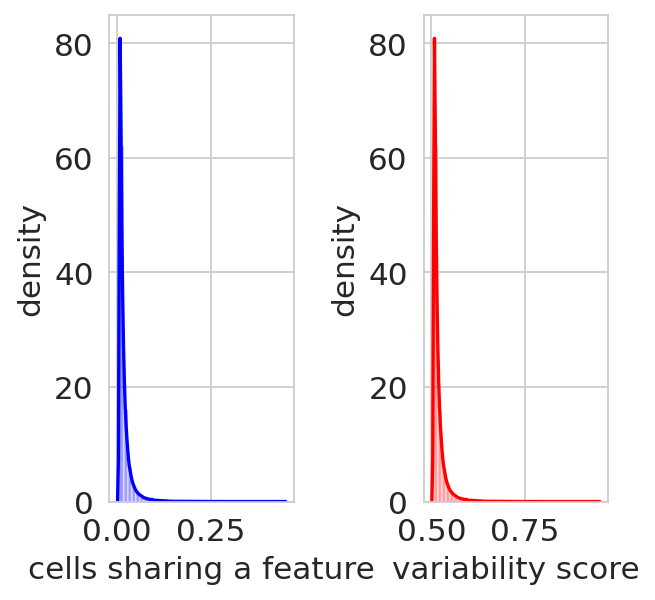

In [16]:
epi.pp.cal_var(adata2)

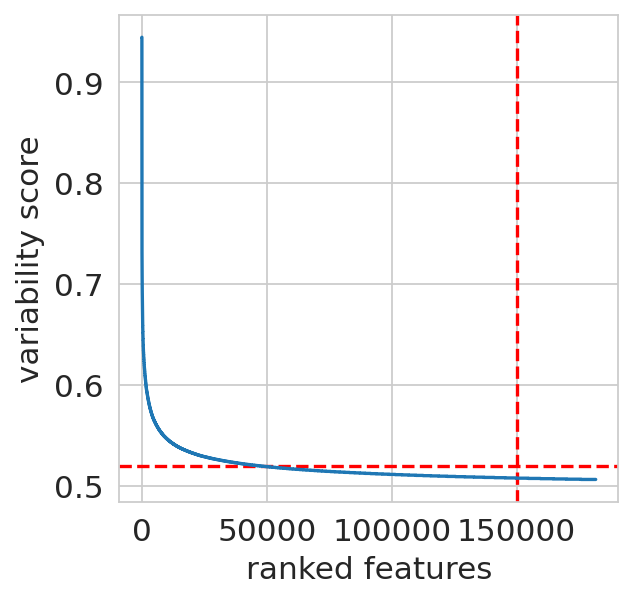

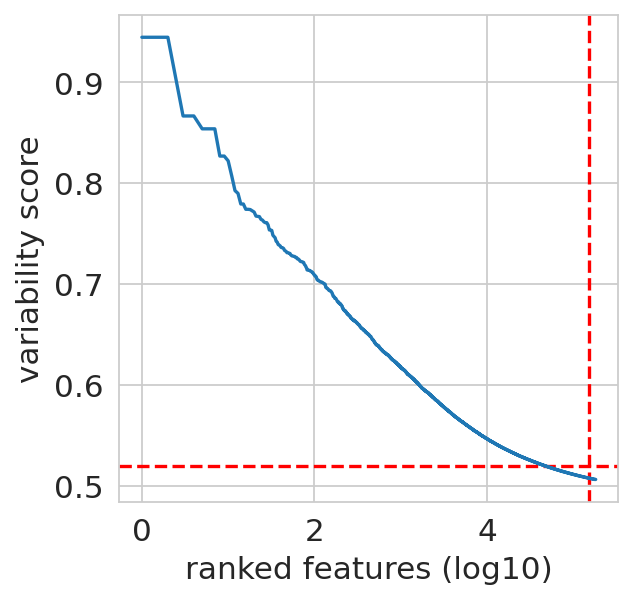

In [17]:
min_score_value = 0.52
nb_feature_selected = 150000
epi.pl.variability_features(adata2,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_CEMBA180305_2B_geneactivity_small_150k.png')

epi.pl.variability_features(adata2,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_CEMBA180305_2B_geneactivity_small_log10_150k.png')

In [18]:
# save the current matrix in the raw layer
adata2.raw = adata2

In [19]:
# create a new AnnData containing only the most variable features
adata2 = epi.pp.select_var_feature(adata2,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

Trying to set attribute `.obs` of view, copying.
... storing 'filter' as categorical


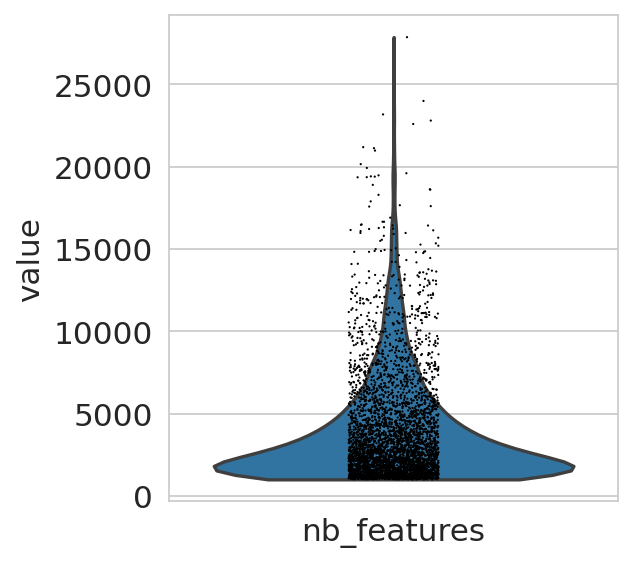

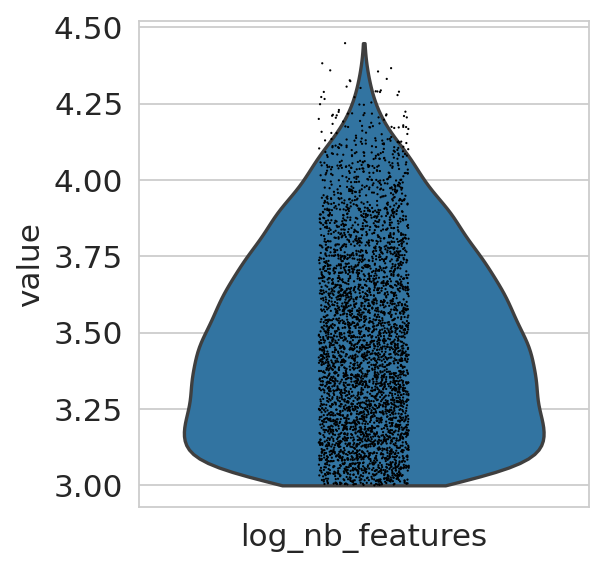

In [20]:
epi.pl.violin(adata2, ['nb_features'])
epi.pl.violin(adata2, ['log_nb_features'])

### Generate the gene activity matrix

In [21]:
adata3 = epi.tl.geneactivity(adata2, gtf_file='gencode.vM23.primary_assembly.annotation.gtf',
                             feature_type='transcript',
                            upstream=5000)

In [22]:
adata3

AnnData object with n_obs × n_vars = 4000 × 3970 
    obs: 'nb_features', 'log_nb_features', 'filter'
    var: 'gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'protein_id'

In [23]:
adata2

AnnData object with n_obs × n_vars = 4000 × 154606 
    obs: 'nb_features', 'log_nb_features', 'filter'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [24]:
adata3.var_names

Index(['Rp1-202', 'St18-213', 'Sntg1-202', 'Mcmdc2-205', 'Snord87-201',
       'Gm24674-201', 'Gm26348-201', 'A830018L16Rik-208', 'Slco5a1-202',
       'Ncoa2-202',
       ...
       'Reps2-201', 'Gm25367-201', 'Gm44376-201', 'Frmpd4-201', 'Mid1-205',
       'Mid1-214', 'Mid1-215', 'Gm47283-201', 'Gm47283-202', 'Gm47283-203'],
      dtype='object', length=3970)

In [25]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata3.layers['counts'] = adata3.X.copy()
adatafang = adata3.copy()

### preview Fang et al. data

... storing 'gene_id' as categorical
... storing 'gene_type' as categorical
... storing 'gene_name' as categorical
... storing 'transcript_type' as categorical
... storing 'protein_id' as categorical


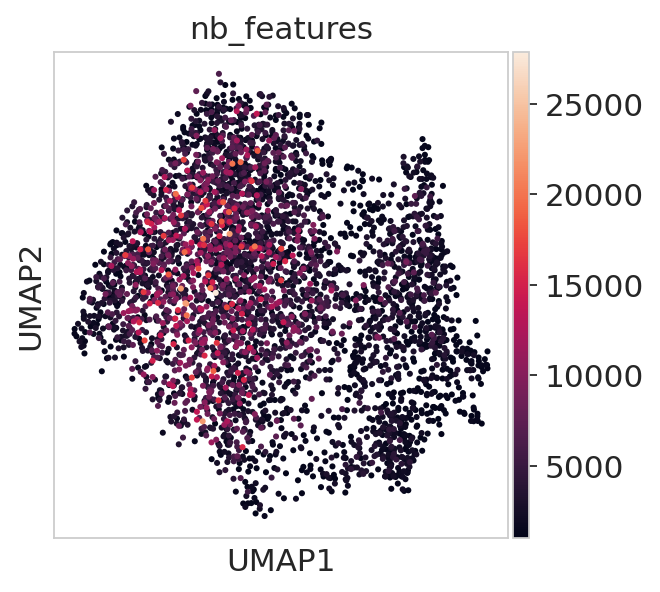

In [51]:
adata5 = adatafang.copy()
epi.pp.normalize_per_cell(adata5)
epi.pp.lazy(adata5)
sc.pl.umap(adata5, color=['nb_features'], wspace=0.3)

In [26]:
# save intermediary file
adatafang.write('./integration_resubmission/gene_activity_fang_small_150k_transcripts.h5ad')

... storing 'gene_id' as categorical
... storing 'gene_type' as categorical
... storing 'gene_name' as categorical
... storing 'transcript_type' as categorical
... storing 'protein_id' as categorical


# Cusanovich small

In [53]:
input_dir_Cusanovich = './data_integration_datasets/cusanovich/merged_peaks_small/'

In [57]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819246_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819247_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adata3 = adatacus1.copy()
adata3.X = adata3.X+adatacus2.X


del adata3.obs['filter'], adatacus1, adatacus2

adata3

AnnData object with n_obs × n_vars = 35018 × 390259 

In [58]:
# make the matrix binary
print(np.max(adata3.X))
epi.pp.binarize(adata3)
print(np.max(adata3.X))

362.0
1.0


### preliminary filtering

In [59]:
# remove any potential empty features or barcodes
epi.pp.filter_cells(adata3, min_features=1)
epi.pp.filter_features(adata3, min_cells=1)
adata3

AnnData object with n_obs × n_vars = 33808 × 390259 
    obs: 'nb_features'
    var: 'n_cells'

### QC plots and filtering

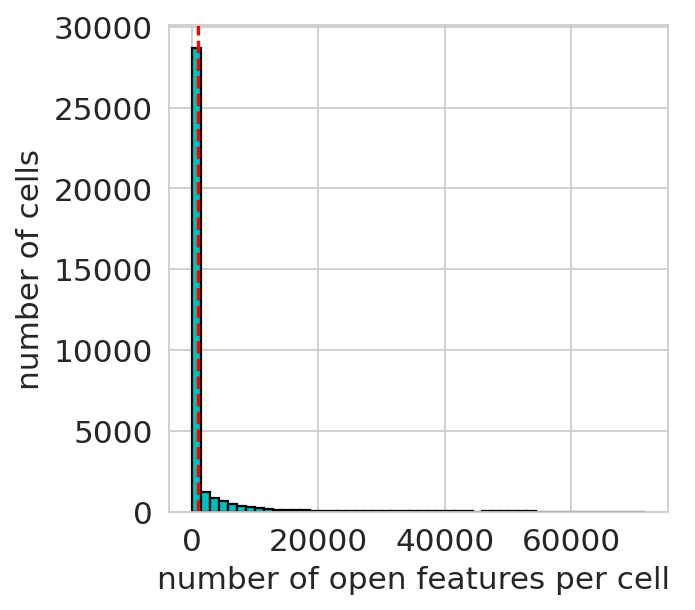

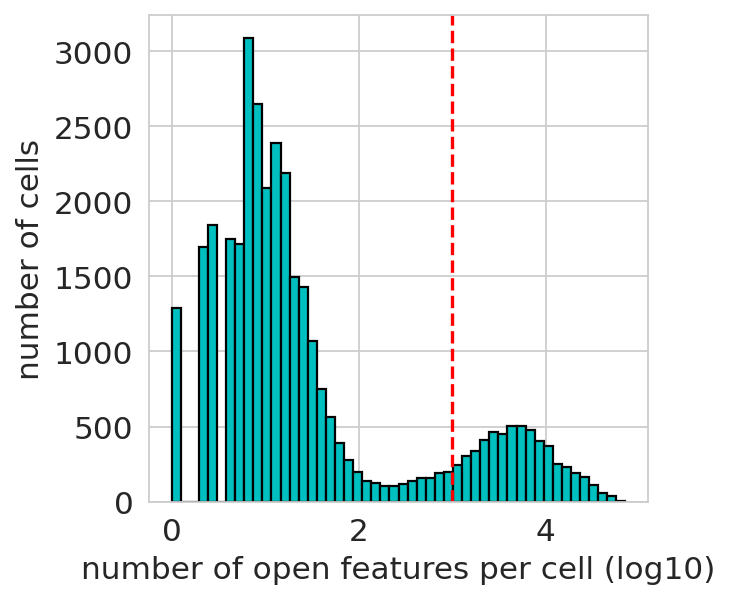

In [60]:
# set a minimum number of cells to keep 
min_features = 1000

epi.pp.coverage_cells(adata3, binary=True, log=False, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_geneactivity_small_150k.png')
epi.pp.coverage_cells(adata3, binary=True, log=10, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_geneactivity_small_log10_150k.png')

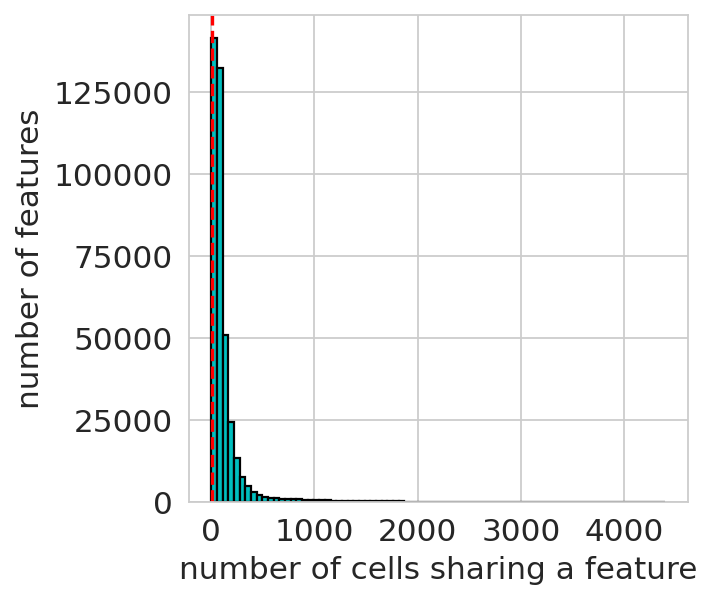

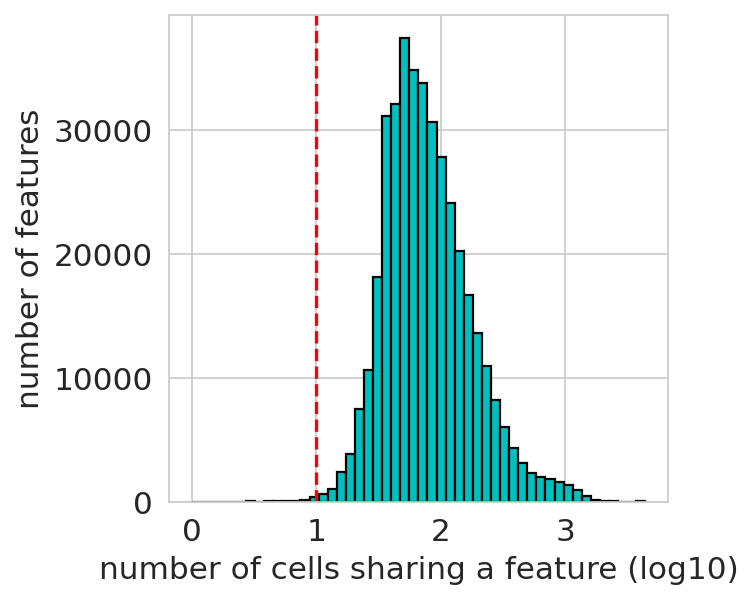

In [61]:
# minimum number of cells sharing a feature
min_cells = 10
epi.pp.coverage_features(adata3, binary=True, log=False, 
                        threshold=min_cells)
epi.pp.coverage_features(adata3, binary=True, log=True, 
                        threshold=min_cells)

In [62]:
min_features = 1000
epi.pp.filter_cells(adata3, min_features=min_features)

In [63]:
min_cells = 10
epi.pp.filter_features(adata3, min_cells=min_cells)

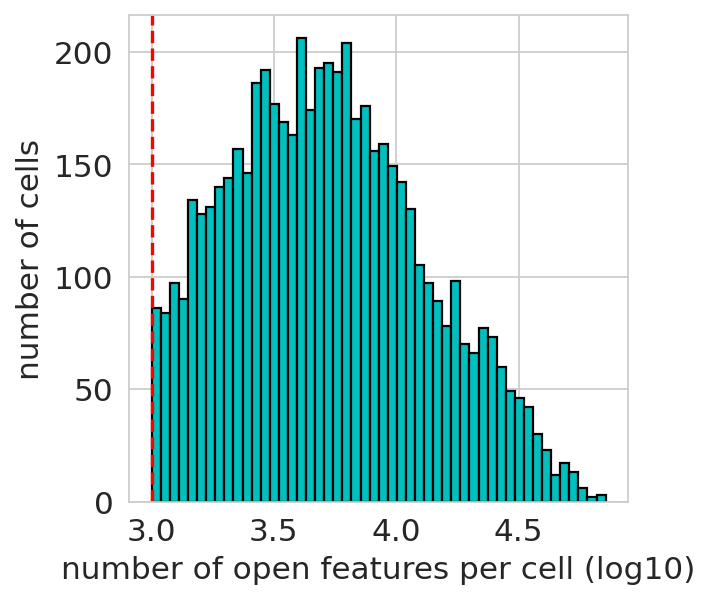

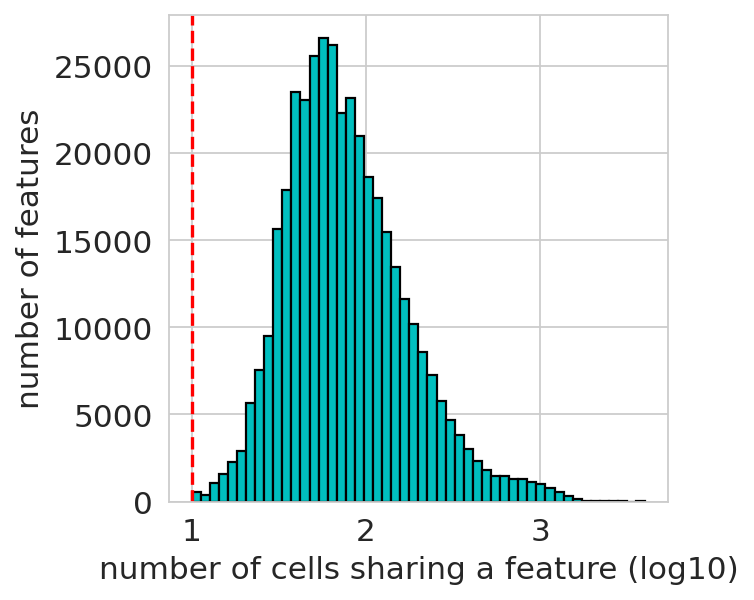

In [64]:
epi.pp.coverage_cells(adata3, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata3, binary=True, log='log10', bins=50, threshold=min_cells)




In [65]:
# subsample cells
k = 4000
filtered_barcodes = random.sample(adata3.obs_names.tolist(), k)
annot = []
for n in adata3.obs_names.tolist():
    if n in filtered_barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata3.obs['filter'] = annot
adata3 = adata3[adata3.obs['filter']=='keep',:].copy()
adata3

AnnData object with n_obs × n_vars = 4000 × 389795 
    obs: 'nb_features', 'filter'
    var: 'n_cells', 'commonness'

### Filter peaks

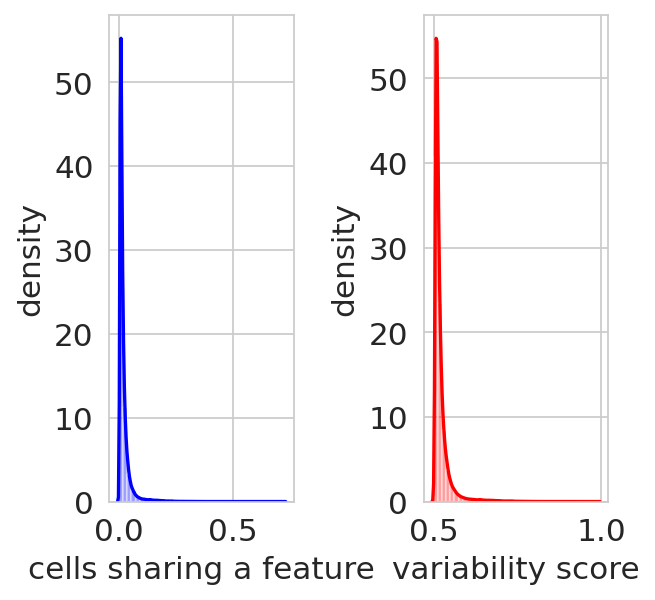

In [66]:
epi.pp.cal_var(adata3)

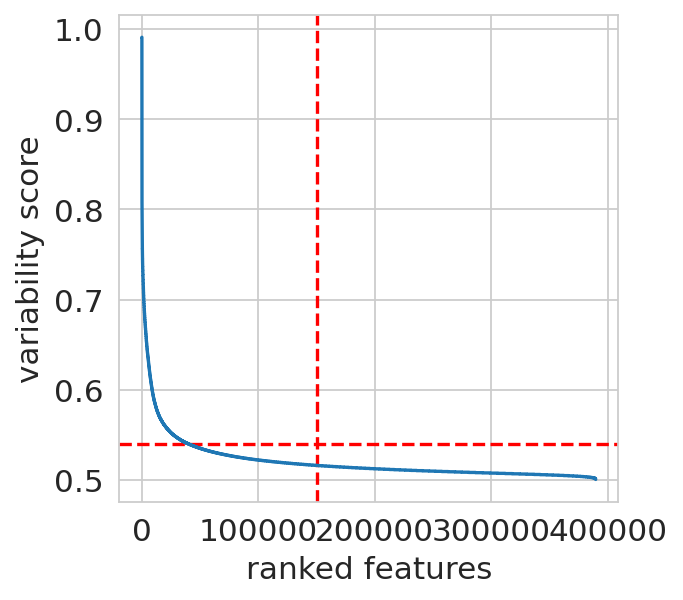

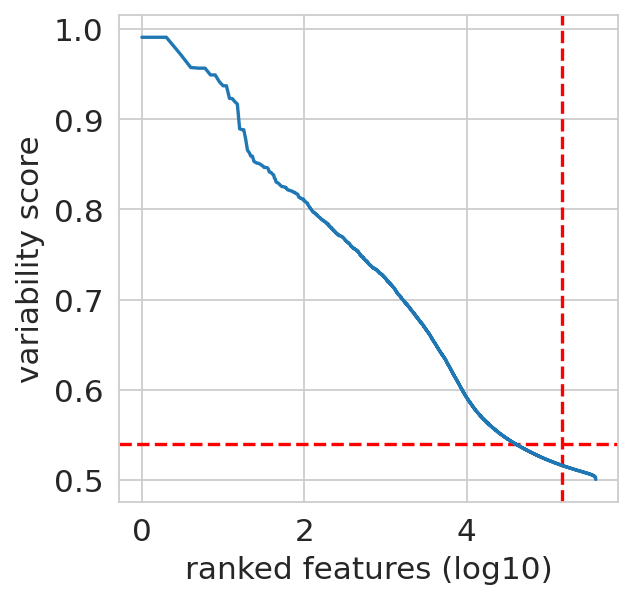

In [67]:
min_score_value = 0.54
epi.pl.variability_features(adata3,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected)

epi.pl.variability_features(adata3,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected)

In [68]:
# save the current matrix in the raw layer
adata3.raw = adata3

In [69]:
# create a new AnnData containing only the most variable features
adata3 = epi.pp.select_var_feature(adata3,
                            nb_features=nb_feature_selected,
                            show=False,
                            copy=True)

In [70]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata3.layers['counts'] = adata3.X.copy()

### Generate the gene activity matrix

In [71]:
adatacus = epi.tl.geneactivity(adata3, gtf_file='gencode.vM23.primary_assembly.annotation.gtf',
                             feature_type='transcript',
                            upstream=5000)

In [72]:
adatacus

AnnData object with n_obs × n_vars = 4000 × 4196 
    obs: 'nb_features', 'filter'
    var: 'gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'protein_id'

### Preview Cusanovich et al.

... storing 'filter' as categorical
... storing 'gene_id' as categorical
... storing 'gene_type' as categorical
... storing 'gene_name' as categorical
... storing 'transcript_type' as categorical
... storing 'protein_id' as categorical


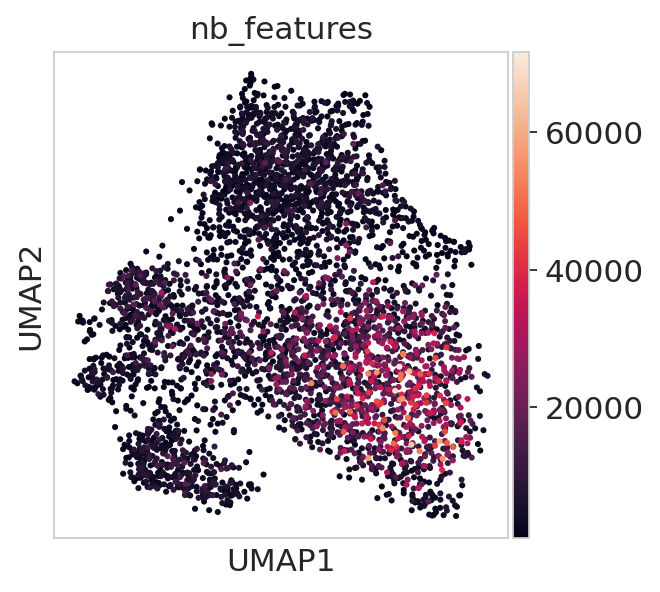

In [73]:
adata6 = adatacus.copy()
epi.pp.normalize_per_cell(adata6)
epi.pp.lazy(adata6)
sc.pl.umap(adata6, color=['nb_features'], wspace=0.3)

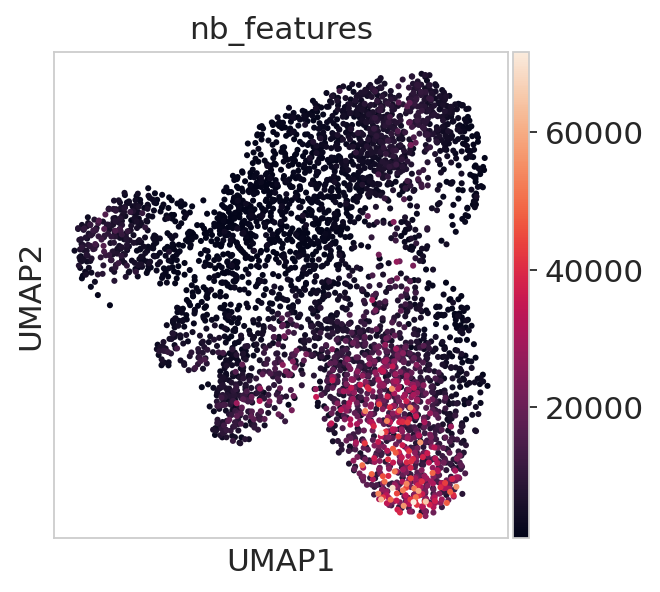

In [74]:
epi.pp.log1p(adata6)
epi.pp.lazy(adata6)
sc.pl.umap(adata6, color=['nb_features'], wspace=0.3)

In [75]:
# save intermediary file
adatacus.write('./integration_resubmission/gene_activity_cus_small_150k_transcript.h5ad')

... storing 'filter' as categorical
... storing 'gene_id' as categorical
... storing 'gene_type' as categorical
... storing 'gene_name' as categorical
... storing 'transcript_type' as categorical
... storing 'protein_id' as categorical
